In [1]:
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# local
from utils import *
sys.path.append("../imaging-utils")
from image_arrays import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

In [3]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_06_16")
stim_labels = ["moving_spot"]

In [4]:
vel_data = {
    stim: {
        depth: {
            int(vel): np.stack(
                [
                    io.imread(os.path.join(data_path, stim, depth, vel, f))
                    for f in os.listdir(os.path.join(data_path, stim, depth, vel))
                    if (f.endswith(".tiff") or f.endswith(".tif"))
                ],
                axis=0
            )
            for vel in os.listdir(os.path.join(data_path, stim, depth))
            if (os.path.isdir(os.path.join(data_path, stim, depth, vel)) and vel.isnumeric())        
        }
        for depth in ["DD", "PD"]
    } for stim in stim_labels
}

vel_df = {
    stim: {
        d: {
            v: ((trials - np.mean(trials[:, 50:100], axis=1, keepdims=True)) 
                / (np.mean(trials[:, 50:100], axis=1, keepdims=True) + 0.00001))
            for v, trials in vels.items()
        }
        for d, vels in depths.items()
    } for stim, depths in vel_data.items()
}

n_trials, n_frames, y_sz, x_sz = vel_data[stim_labels[0]]["DD"][300].shape
dt = 1 / 565
recs_xaxis = np.arange(n_frames) * dt
velocities = np.array(list(sorted(vel_data[stim_labels[0]]["DD"].keys())))
print("velocity stack shape:", vel_data[stim_labels[0]]["DD"][300].shape)

velocity stack shape: (2, 450, 256, 256)


### Dynamic ROI plot of a scan (of particular `depth`) during stimulation by spot moving at `vel` 

<IPython.core.display.Javascript object>


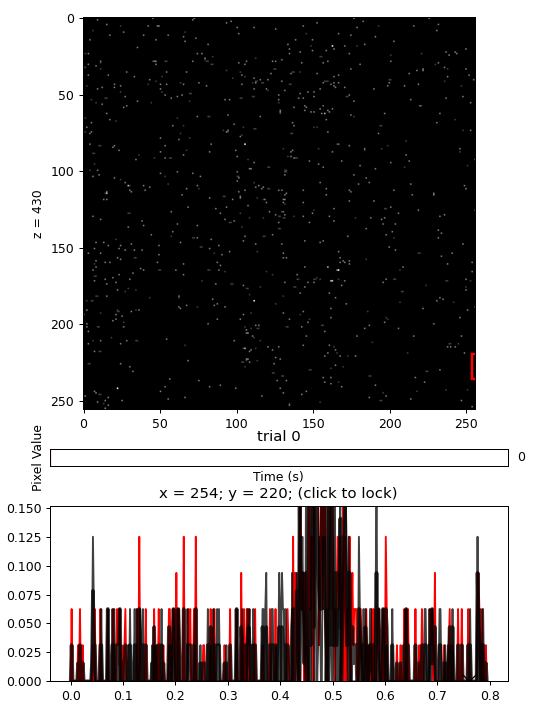

In [7]:
vel = 300
stim = "moving_spot"
depth = "PD"

stack_plot = StackExplorer(
    vel_data[stim][depth][vel],
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=(16, 16),
    vmin=0,
    figsize=(6, 8)
)
stack_plot.ax[1].set_xlabel("Time (s)")
stack_plot.ax[1].set_ylabel("Pixel Value")
stack_plot.fig.show()

### Grid ROI placement
Take `grid_w` by `grid_h` beams from the scan field

In [11]:
grid_w = 16
grid_h = 16

def aligned_avg(avg_recs):
    filtered = np.stack([savgol_filter(r, 71, 3) for r in avg_recs], axis=0)
    max_idxs = np.argmax(filtered, axis=1)
    shifts = max_idxs - np.min(max_idxs)
    trim = np.max(shifts)
    aligned = np.mean(
        [r[s:(-trim + s) if s != trim else None] for r, s in zip(avg_recs, shifts)],
        axis=0
    )
    return aligned
    
grid_recs, avg_grid_recs, aligned_grid_avg, grid_locs = {}, {}, {}, {}
for depth, vels in vel_data[stim].items():
    grid_recs[depth], avg_grid_recs[depth], grid_locs[depth] = {}, {}, {}
    aligned_grid_avg[depth] = {}
    for v, stack in vels.items():
        recs, locs = [], []
        for x0 in range(0, x_sz, grid_w):
            for y0 in range(0, y_sz, grid_h):
                beams = np.mean(stack[:, :, y0:y0 + grid_h, x0:x0 + grid_w], axis=(2, 3))
                recs.append(beams)
                locs.append([x0, y0])        
        grid_recs[depth][v] = np.stack(recs, axis=1)
        avg_grid_recs[depth][v] = np.mean(grid_recs[depth][v], axis=0)
        grid_locs[depth][v] = np.stack(locs, axis=0)
        aligned_grid_avg[depth][v] = aligned_avg(avg_grid_recs[depth][v])

<IPython.core.display.Javascript object>


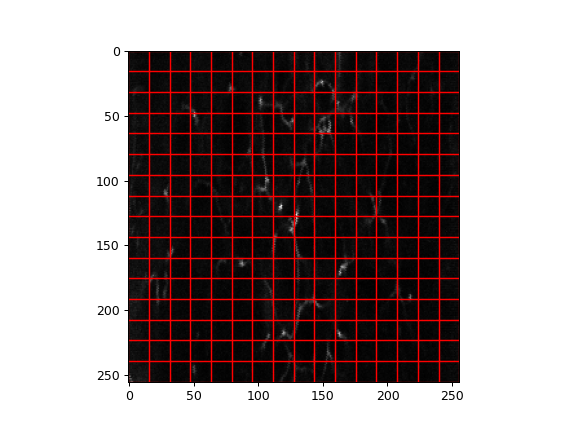

In [13]:
depth = "PD"
vel = 300

mean_stack_proj = np.mean(vel_data[stim][depth][vel], axis=(0,1))

half_w = grid_w / 2
half_h = grid_h / 2
grid_fig, grid_ax = plt.subplots(1)

grid_ax.imshow(mean_stack_proj, cmap="gray")
for (x, y) in grid_locs[depth][vel]:
    grid_ax.add_patch(
        Rectangle(
            (x - .5, y - .5),  # grid offset
            grid_w, 
            grid_h, 
            fill=False,
            color="red",
            linewidth=1,
            linestyle="-"
        )
    )

### Use PeakExplorer to browse through ROIs (scroll wheel) of from the average scans taken from `depth` during `vel` stimulation  

<IPython.core.display.Javascript object>


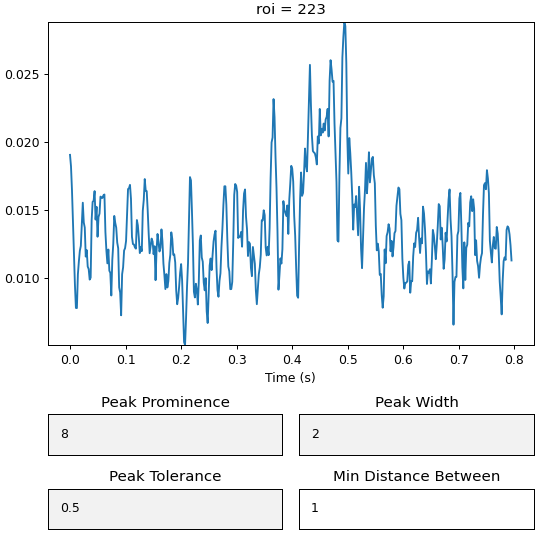

In [14]:
depth = "PD"
vel = 300


filtered = np.stack(
    [savgol_filter(roi, 11, 3) for roi in avg_grid_recs[depth][vel]], 
    axis=0
)

peak_explorer = PeakExplorer(
    recs_xaxis, 
#     grid_recs[depth][vel][0],
#     avg_grid_recs[depth][vel],
    filtered,
    prominence=8,
    width=2,
    tolerance=.5,
    distance=1
)

### Perform biexponential fits on waveforms from either a particulal grid roi, or the peak aligned average of all the ROIs

In [16]:
grid_idx = 0
norm_amp_fitting = False
use_aligned = False
rec_dict = aligned_grid_avg if use_aligned else avg_grid_recs

fits, fitted_recs = {}, {}
for depth, vels in rec_dict.items():
    fits[depth], fitted_recs[depth] = {}, {}
    for v, recs in sorted(vels.items()):
        if use_aligned:
            y = savgol_filter(recs, 91, 3)
        else:
            y = savgol_filter(recs[grid_idx], 21, 3)
        i0 = find_rise_bsln(y, step=5, bsln_start=50, bsln_end=100)
        y_sub = y[i0:] - y[i0]
        y_norm = y_sub / y_sub.max()
        x_trunc = np.arange(len(y) - i0) * dt
        fitter = BiexpFitter(0.05, 0.055, norm_amp=norm_amp_fitting)
        fitter.fit(x_trunc, y_norm)
        g = fitter.calc_g(x_trunc)
        print(
            "[%s, %i] -> tau1: %.4f; tau2: %.4f" %
            (
                depth,
                v,
                fitter.results.params["tau1"], 
                fitter.results.params["tau2"]
            )
        )
        fits[depth][v] = {"g": g, **fitter.results.params}
        fitted_recs[depth][v] = y_norm

aligned_tag = "_aligned" if use_aligned else ""
if norm_amp_fitting:
    pack_hdf(os.path.join(data_path, "velocity_tau_fits_normed_peaks" + aligned_tag), fits)
else:
    pack_hdf(os.path.join(data_path, "velocity_tau_fits" + aligned_tag), fits)    

[DD, 100] -> tau1: 0.0139; tau2: 0.1061
[DD, 300] -> tau1: 0.0375; tau2: 0.1105
[DD, 500] -> tau1: 0.0296; tau2: 0.0839
[DD, 1000] -> tau1: 0.0110; tau2: 0.0460
[DD, 2000] -> tau1: 0.0109; tau2: 0.0473
[DD, 3000] -> tau1: 0.0698; tau2: 0.1442
[DD, 4000] -> tau1: 0.0084; tau2: 0.0352
[DD, 5000] -> tau1: 0.0039; tau2: 0.0265
[PD, 100] -> tau1: 0.0388; tau2: 0.1359
[PD, 300] -> tau1: 0.0227; tau2: 0.1613
[PD, 500] -> tau1: 0.0302; tau2: 0.0971
[PD, 1000] -> tau1: 0.0109; tau2: 0.0622
[PD, 2000] -> tau1: 0.0173; tau2: 0.0541
[PD, 3000] -> tau1: 0.0132; tau2: 0.1433
[PD, 4000] -> tau1: 0.0042; tau2: 0.0265
[PD, 5000] -> tau1: 0.0444; tau2: 0.1478


<IPython.core.display.Javascript object>


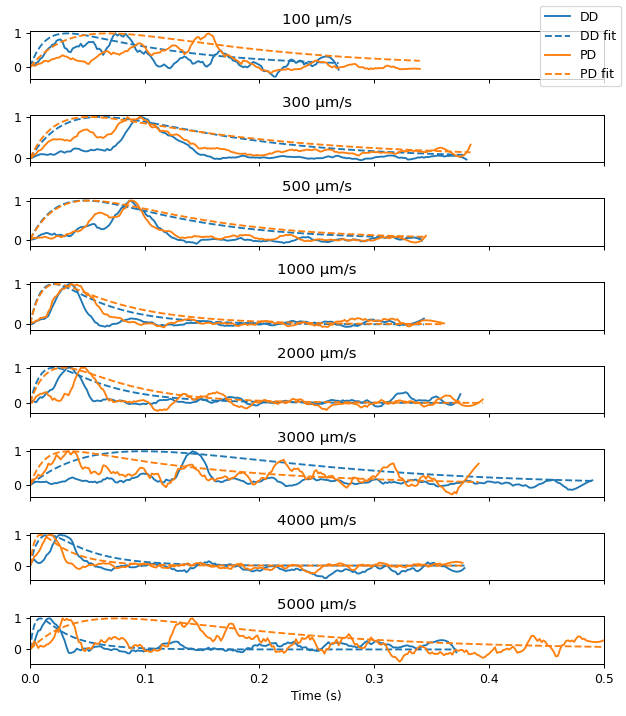

In [19]:
def biexp(x, m, t1, t2, b):
    return m * (np.exp(-t1 * x) - np.exp(-t2 * x)) + b

def mono_exp_decay(x, m, t, b):
    return m * np.exp(-t * x) + b

fit_tau_fig, fit_tau_ax = plt.subplots(len(velocities), sharex=True, figsize=(7, 8))
for i, (ax, vel) in enumerate(zip(fit_tau_ax, velocities)):
    for j, depth in enumerate(vel_data[stim].keys()):
        x = np.arange(len(fitted_recs[depth][vel])) * dt
        norm_fit = fits[depth][vel]["g"] / np.max(fits[depth][vel]["g"])
        ax.plot(x, fitted_recs[depth][vel], c="C%i" % j, label=depth if not i else None)
        ax.plot(
            x, norm_fit, c="C%i" % j, linestyle="--", 
            label=(("%s fit" % depth) if not i else None)
        )
        ax.set_title("%i μm/s" % vel)
    ax.set_xlim(0, .5)

ax.set_xlabel("Time (s)")
fit_tau_fig.legend()
fit_tau_fig.tight_layout()

### Tau falloffs over velocity

In [ ]:
tune_fig, tune_ax = plt.subplots(2, sharex=True)
for ax, (depth, vels) in zip(tune_ax, fits.items()):
    tau1 = [vels[v]["tau1"] for v in velocities]
    tau2 = [vels[v]["tau2"] for v in velocities]
    t1_coefs = np.polyfit(velocities, tau1, deg=2)
    t2_coefs = np.polyfit(velocities, tau2, deg=2)
    ax.scatter(velocities, tau1, marker="+", label="tau1")
    ax.scatter(velocities, tau2, marker="x", label="tau2")
    ax.plot(velocities, np.poly1d(t1_coefs)(velocities))
    ax.plot(velocities, np.poly1d(t2_coefs)(velocities))
    ax.set_title(depth)

for a in tune_ax:
    a.set_ylabel("Time Constant (s)")
    a.set_ylim(0)
    a.legend()
    
tune_ax[0].set_title("DD")
tune_ax[1].set_xlabel("Velocity (μm/s)")
tune_fig.show()

### Comparison between ROIs (or aligned averages) of DD and PD depths for each velocity 

In [ ]:
grid_idxs = {"DD": 5, "PD": 5}
# grid_idxs = {"DD": 0, "PD": 0}
use_aligned = True

norm = True
depth_comp_fig, depth_comp_ax = plt.subplots(len(velocities), sharex=True, figsize=(6, 8))
for ax, vel in zip(depth_comp_ax, velocities):
#     if vel == 3000:
#         continue
    for depth in vel_data.keys():
        if use_aligned:
            y = savgol_filter(aligned_grid_avg[depth][vel], 21, 3)
        else:
            y = savgol_filter(avg_grid_recs[depth][vel][grid_idxs[depth]], 11, 3)
#         y = avg_grid_recs[depth][vel][3]
#         y = savgol_filter(grid_recs[depth][vel][1, 2], 21, 3)
        x = np.arange(len(y)) * dt
        if norm:
            y /= y.max()
        ax.plot(x, y, label=depth)
        ax.set_title("%i μm/s" % vel)
        ax.legend()
        ax.set_xlim(4, 5.7)

depth_comp_ax[-1].set_xlabel("Time (s)")
depth_comp_fig.tight_layout()

### Prerna Waveforms, first N (2021_05_11)
Waveforms extracted by Prerna, used for powerpoint

In [ ]:
waveforms = {d: {v: [] for v in velocities} for d in ["DD", "PD"]}
for f in os.listdir(os.path.join(data_path, "waveforms2")):
    waves = pd.read_csv(os.path.join(data_path, "waveforms2", f), skiprows=1).values.T
    for v, w in zip(velocities, waves):
        if not np.isnan(w).any():
            waveforms[f[:2]][v].append(w)

waveforms = {
    d: {v: np.stack(ws, axis=0) for v, ws in vels.items()} 
    for d, vels in waveforms.items()
}

avg_waveforms = {
    d: {v: np.mean(ws, axis=0) for v, ws in vels.items()} 
    for d, vels in waveforms.items()
}

### Manual fitting (bespoke adjustment of taus to line them up by eye)

In [ ]:
manual_taus = {
    "DD": {
        # TODO: fudged 300 and 500 taus to matche the ppt better
        300: {"tau1": 0.14, "tau2": 0.15},
        500: {"tau1": 0.12, "tau2": 0.120001},
        1000: {"tau1": 0.1, "tau2": 0.11},
        2000: {"tau1": 0.045, "tau2": 0.05},
        3000: {"tau1": 0.035, "tau2": 0.04},
        4000: {"tau1": 0.030, "tau2": 0.031},
        5000: {"tau1": 0.03, "tau2": 0.031},
    },
    "PD": {
        # TODO: fudged 300 and 500 taus to matche the ppt better
        300: {"tau1": 0.45, "tau2": 0.4500001},
        500: {"tau1": 0.3, "tau2": 0.30001},
        1000: {"tau1": 0.15, "tau2": 0.150001},
        2000: {"tau1": 0.045, "tau2": 0.05},
        3000: {"tau1": 0.035, "tau2": 0.04},
        4000: {"tau1": 0.029, "tau2": 0.03},
        5000: {"tau1": 0.029, "tau2": 0.03},
    },
}
# manual_taus = {
#     "DD": {
#         # TODO: fudged 300 and 500 taus to matche the ppt better
#         300: {"tau1": 0.10, "tau2": 0.1001},
#         500: {"tau1": 0.08, "tau2": 0.080001},
#         1000: {"tau1": 0.07, "tau2": 0.0701},
#         2000: {"tau1": 0.045, "tau2": 0.05},
#         3000: {"tau1": 0.035, "tau2": 0.04},
#         4000: {"tau1": 0.030, "tau2": 0.031},
#         5000: {"tau1": 0.03, "tau2": 0.031},
#     },
#     "PD": {
#         # TODO: fudged 300 and 500 taus to matche the ppt better
#         300: {"tau1": 0.45, "tau2": 0.4500001},
#         500: {"tau1": 0.3, "tau2": 0.30001},
#         1000: {"tau1": 0.15, "tau2": 0.150001},
#         2000: {"tau1": 0.045, "tau2": 0.05},
#         3000: {"tau1": 0.035, "tau2": 0.04},
#         4000: {"tau1": 0.029, "tau2": 0.03},
#         5000: {"tau1": 0.029, "tau2": 0.03},
#     },
# }

dummy = BiexpFitter(0.057, .116, norm_amp=True)

manual_tau_fig, manual_tau_ax = plt.subplots(len(velocities), sharex=True, figsize=(7, 8))
for i, (ax, vel) in enumerate(zip(manual_tau_ax, velocities)):
    for j, depth in enumerate(vel_data.keys()):
        x = np.arange(1.5 / dt) * dt
        fit = dummy.model(
            t=x, 
            tau1=manual_taus[depth][vel]["tau1"],
            tau2=manual_taus[depth][vel]["tau2"],
            y0=1.,
        )[0]
        manual_taus[depth][vel]["g"] = fit
        wave = avg_waveforms[depth][vel] / avg_waveforms[depth][vel].max()
        if depth == "DD":  # use the index from DD
            rise_idx = find_rise_bsln(wave, bsln_start=1000, bsln_end=2000)
        if not i:
            wave_lbl = depth
            fit_lbl = "%s fit" % depth
        else:
            wave_lbl, fit_lbl = None, None
        ax.plot(x, wave[rise_idx:rise_idx + len(x)], c="C%i" % j, label=wave_lbl)
        ax.plot(x, fit, linestyle="--", c="C%i" % j, label=fit_lbl)
        ax.set_title("%i μm/s" % vel)
        
manual_tau_fig.legend()
manual_tau_fig.tight_layout()

pack_hdf(os.path.join(data_path, "manual_tau_fits"), manual_taus)

### Prerna Waveforms, second N (2021_05_12)
Waveforms from another experimental day.

In [ ]:
data_path_2 = os.path.join(base_path, "2021_05_12")
velocities_2 = np.array([100, 300, 500, 1000, 2000, 3000, 4000, 5000])

waveforms_2 = {d: {v: [] for v in velocities_2} for d in ["DD", "PD"]}
for f in os.listdir(os.path.join(data_path_2, "waveforms")):
    waves = pd.read_csv(os.path.join(data_path_2, "waveforms", f), skiprows=1).values.T
    for v, w in zip(velocities_2, waves):
        if not np.isnan(w).any():
            waveforms_2[f[:2]][v].append(w)

waveforms_2 = {
    d: {v: np.stack(ws, axis=0) for v, ws in vels.items()}
    for d, vels in waveforms_2.items()
}

avg_waveforms_2 = {
    d: {v: np.mean(ws, axis=0) for v, ws in vels.items()} 
    for d, vels in waveforms_2.items()
}

In [ ]:
manual_taus_2 = {
    "DD": {
        100: {"tau1": 0.15, "tau2": 0.16},
        300: {"tau1": 0.15, "tau2": 0.16},
        500: {"tau1": 0.12, "tau2": 0.120001},
        1000: {"tau1": 0.05, "tau2": 0.07},
        2000: {"tau1": 0.045, "tau2": 0.05},
        3000: {"tau1": 0.035, "tau2": 0.04},
        4000: {"tau1": 0.030, "tau2": 0.031},
        5000: {"tau1": 0.03, "tau2": 0.031},
    },
    "PD": {
        100: {"tau1": 0.15, "tau2": 0.16},
        300: {"tau1": 0.23, "tau2": 0.24},
        500: {"tau1": 0.15, "tau2": 0.17},
        1000: {"tau1": 0.07, "tau2": 0.09},
        2000: {"tau1": 0.045, "tau2": 0.05},
        3000: {"tau1": 0.035, "tau2": 0.04},
        4000: {"tau1": 0.029, "tau2": 0.03},
        5000: {"tau1": 0.029, "tau2": 0.03},
    },
}

# dummy = BiexpFitter(0.057, .116, norm_amp=True)

manual_tau_2_fig, manual_tau_2_ax = plt.subplots(
    len(velocities_2), sharex=True, figsize=(7, 8))
for i, (ax, vel) in enumerate(zip(manual_tau_2_ax, velocities_2)):
    for j, depth in enumerate(vel_data.keys()):
        x = np.arange(7.5 / dt) * dt
#         x = np.arange(2.0 / dt) * dt
#         fit = dummy.model(
#             t=x, 
#             tau1=manual_taus_2[depth][vel]["tau1"],
#             tau2=manual_taus_2[depth][vel]["tau2"],
#             y0=1.,
#         )[0]
#         manual_taus_2[depth][vel]["g"] = fit
        wave = avg_waveforms_2[depth][vel] / avg_waveforms_2[depth][vel][2000:].max()
        if depth == "DD":  # use the index from DD
            rise_idx = find_rise_bsln(wave, bsln_start=1000, bsln_end=2000)
        if not i:
            wave_lbl = depth
            fit_lbl = "%s fit" % depth
        else:
            wave_lbl, fit_lbl = None, None
        rise_idx = 0
        ax.plot(x, wave[rise_idx:rise_idx + len(x)], c="C%i" % j, label=wave_lbl)
#         ax.plot(wave[2000:], c="C%i" % j, label=wave_lbl)
#         ax.plot(x, fit, linestyle="--", c="C%i" % j, label=fit_lbl)
        ax.set_title("%i μm/s" % vel)
        ax.set_xlim(4)

manual_tau_2_fig.legend()
manual_tau_2_fig.tight_layout()

pack_hdf(os.path.join(data_path_2, "manual_tau_fits"), manual_taus_2)

### Comparison between ROIs of the same scan (consistent?)

In [ ]:
vel = 300
align = True
keep_rois = None
# keep_rois = {0, 3}

roi_fall_fig, roi_fall_ax = plt.subplots(2, sharex=True, figsize=(8, 8))
for a, depth in zip(roi_fall_ax, ["DD", "PD"]):
    for i, roi in enumerate(avg_grid_recs[depth][vel]):
        if keep_rois is not None and i not in keep_rois:
            continue
        w = savgol_filter(roi, 21, 3)
        w -= np.mean(w[1000:2000])
        w /= np.max(w)
        if align:
            x = (np.arange(len(w)) - np.argmax(w)) * dt
        else:    
            x = np.arange(len(w)) * dt
        a.plot(x, w, label=("roi %i" % i) if depth == "DD" else None)
    if align:
        a.set_xlim(-.5, 1)
    else:
        a.set_xlim(4, 6)
    a.set_title(depth)
    
a.set_xlabel("Time%s(s)" % (" relative to peak " if align else " "))
roi_fall_fig.legend()
roi_fall_fig.show()

### DD vs PD for each ROI of the avg trial scan (same relationship throughout?)

In [ ]:
vel = 300
align = False
sub_bsln = False
norm = False
# rois = [0, 3]
rois = [0, 1, 3, 4, 5, 6, 7]

roi_compare_fig, roi_compare_ax = plt.subplots(len(rois), sharex=True, figsize=(8, 8))
for a, i in zip(roi_compare_ax, rois):
    for depth in ["DD", "PD"]:
        w = savgol_filter(avg_grid_recs[depth][vel][i], 31, 3)
        if sub_bsln:
            w -= np.mean(w[1000:2000])
        if norm:
            w /= np.max(w)
        if align:
            x = (np.arange(len(w)) - np.argmax(w)) * dt
        else:    
            x = np.arange(len(w)) * dt
        a.plot(x, w, label=depth)
    if align:
        a.set_xlim(-.5, 1)
    else:
        a.set_xlim(4, 6)
    a.set_title("roi %i" % i)
    a.legend()
    
a.set_xlabel("Time (s)")
roi_compare_fig.tight_layout()
roi_compare_fig.show()

### Peak, area, and peak-time metrics for each of the ROIs (averaged trials)

In [ ]:
metrics = {}
for depth, vels in avg_grid_recs.items():
    metrics[depth] = {"peak": [], "area": [], "peak_time": []}
    for v in velocities:
        acc = {k: [] for k in metrics[depth].keys()}
        for roi in vels[v]:
            filt = savgol_filter(roi, 11, 3)
            acc["peak"].append(np.max(filt))
            acc["area"].append(np.mean(filt))
            acc["peak_time"].append(recs_xaxis[np.argmax(filt)])
        for k, v in acc.items():
            metrics[depth][k].append(v)
    metrics[depth] = {k: np.array(v).T for k, v in metrics[depth].items()}

peak_vel_fig, peak_vel_ax = plt.subplots(
    len(metrics["DD"]), 2, sharex=True, sharey="row", figsize=(6, 8)
)
peak_vel_ax = list(map(list, zip(*peak_vel_ax))) # transpose to column major
for i, (col, (depth, ms)) in enumerate(zip(peak_vel_ax, metrics.items())):
    for j, (ax, (k, v)) in enumerate(zip(col, ms.items())):
        for roi_idx, roi in enumerate(v):
            ax.plot(velocities, roi / roi[0], marker="o", linestyle="--")
            if not j:
                col[0].set_title(depth)
    
        if not i:
            ax.set_ylabel("%s" % k)
    col[-1].set_xlabel("Velocity")
    
peak_vel_fig.tight_layout()
peak_vel_fig.show()

### Rough estimate of the temporo-spatial offset required to optimize the summation of the proximal and distal inputs (using the average waveforms from Prerna)

In [ ]:
vel = 300
step = 50
n = 15
lag_sums = np.stack(
    [
        (avg_waveforms["DD"][vel] 
         + np.concatenate([avg_waveforms["PD"][vel][i * step:], np.zeros(i * step)]))
        for i in range(n)
    ]
)

offsets = np.arange(n) * -step * dt * 1000
lag_peaks = np.max(lag_sums, axis=1)

lag_sum_fig, lag_sum_ax = plt.subplots(2)

for s, off in zip(lag_sums[:5], offsets):
    lag_sum_ax[0].plot(recs_xaxis[:-1], s, label="prox %ims early" % off)
lag_sum_ax[0].set_xlim(4.2, 5.75)
lag_sum_ax[0].set_xlabel("Time (s)")

lag_sum_ax[1].plot(offsets, lag_peaks / np.max(lag_peaks))
lag_sum_ax[1].set_ylabel("Normalized Peak")
lag_sum_ax[1].set_xlabel("Proximal Offset (ms)")

lag_sum_fig.suptitle("Optimal Proximal -> Distal Timing")
lag_sum_fig.legend()
lag_sum_fig.tight_layout()

optimal_dist = offsets[np.argmax(lag_peaks)] * vel / -1000
print("Optimal prox -> dist offset for %i um/s: %.2fum" % (vel, optimal_dist))